In [1]:
import numpy as np
import matplotlib.animation
import matplotlib.pyplot as plt
import random
from IPython.display import HTML
from matplotlib import animation
import timeit

In [2]:
def energy(sigma, J, H):
    ''' Calculate lattice Energy from Hamiltonian
        E = -J * sum(S(i)*S(j);i^j) - H * sum(S(j);j)
     Parameters
     ----------
     sigma : Full lattice that includes boundaries
     H : External field
     J : Interaction 
    '''
    return (-J * np.sum(sigma[:-1,:] * sigma[1:,:]) + -J * np.sum(sigma[:,:-1] * sigma[:,1:]) + -H * np.sum(sigma))

In [3]:
def setBoundary(sigma):
    sigma[0,:]  = sigma[-1,:]
    sigma[-1,:] = sigma[-2,:]
    sigma[:,0]  = sigma[1,:]
    sigma[:,-1] = sigma[2,:]
    return

In [4]:
def mcflip_sublat(sigma,a,b, J, H):
    """Update on sublattices defined by and randomly flip with probability
    set by the relative Gibbs weight."""
    
    # localH acts on the bulk sublattice which is defined by the slice
    # sigma[1+a:-1:2, 1+b:-1:2]
    Lx, Ly = sigma.shape
    localH = H* sigma[1+a:-1:2, 1+b:-1:2] + J * sigma[1+a:-1:2, 1+b:-1:2]*(
            sigma[2+a:   :2, 1+b: -1:2] + # to the right
            sigma[  a: -2:2, 1+b: -1:2] + # to the left
            sigma[1+a: -1:2, 2+b:   :2] + # up
            sigma[1+a: -1:2,   b: -2:2]   # down 
            )
    
    #metropolis probability:
    p = np.exp(-2 * localH)
    sigma[1+a:-1:2, 1+b:-1:2] *= -1 * (2*(np.random.rand(Lx//2-1,Ly//2-1) < p) - 1)          
    return

In [5]:
#flips the spins and sets the periodic boundaries
def mcflip(sigma, J, H):
    setBoundary(sigma)
    mcflip_sublat(sigma,0,0, J, H)
    setBoundary(sigma)  
    mcflip_sublat(sigma,1,0, J, H)
    setBoundary(sigma)  
    mcflip_sublat(sigma,0,1, J, H)
    setBoundary(sigma)  
    mcflip_sublat(sigma,1,1, J, H)
    setBoundary(sigma)  
    return

In [6]:
def acf(x, length=20):
    ''' Auto Correlation Function'''
    return np.array([1]+[np.corrcoef(x[:-i], x[i:])[0,1]  \
    for i in range(1, length)])

In [7]:
def tp_corr(sigma,n,length=50):#two point correlation function 
    L=len(sigma)
    C=[]
    for i in range(1,length):
        Xi=[]
        Xj=[]
        for j in range(n):
            x=np.random.randint(0,L)
            y=np.random.randint(0,L)
            Xi+=[sigma[x][y]]
            Xj+=[sigma[x][(y+i)%L]]
        Xi=np.array(Xi)
        Xj=np.array(Xj)
        C+=[(np.mean(Xi*Xj)-np.mean(Xi)*np.mean(Xj))/np.var(Xi)]     
    return C

In [8]:
def corr_len(auto_corr):
    for i, ac in enumerate(auto_corr):
        if (np.abs(ac - (1/np.e)) <= 0.005) and (np.abs(ac - (1/np.e)) < np.abs(auto_corr[(i+1)%len(auto_corr)] - (1/np.e))):
            return i

In [9]:
def magnetization(sigma):
    return np.mean(sigma[1:-1,1:-1]) # exclude boundary spins

In [10]:
def runSample(nSteps = 10000, subSample = 10):
    """Run nSteps Monte Carlo sweeps on the 2D Ising model.
       Does not initialize the sample so can be called sequentially without
       reinitialization if desired.
   
       Returns:
           histMag -- array of magnetizations at every subSample timesteps
           histEn  -- array of energies at every subSample timesteps
   """
   
   # create lists to grow
    histMag = []
    histEn = []
        
    for t in range(nSteps):
        mcflip(sigma, J, H)
                 
        if t % subSample == 0:
            histMag.append(magnetization(sigma))
            histEn.append(energy(sigma, J, H))
    # return as arrays
    return (np.array(histMag), np.array(histEn))

In [11]:
def run_sample_ksi(nSteps = 10000, subSample = 10):
    """this function takes samples to calculate the positional correlation length 
       using the functions tp_corr
    """
    histksi = []
    for t in range(nSteps):
        mcflip(sigma, J, H)    
        if t % subSample == 0:
            ksi=corr_len(tp_corr(sigma,50,length=20))
            if ksi is not None: 
                histksi.append(ksi)
            else:
                histksi.append(0)
    # return as arrays
    return np.array(histksi)

In [12]:
def Generate(sigma,J,H):
    '''
    this function is the automatic data creator from our simulation
    it takes 6000 samples at first, dumps the first 2000 and then goes on with the method 
    explained in the report to sample efficiently and with good quality
    '''
    Mag0, En0= runSample(6000,1) 
    ac = acf(Mag0[2000:],length=900)
    step = corr_len(ac)
    Mag, En = Mag0[2000::step], En0[2000::step]
    if step is None:                              #when step is less than 1 we set step=1
        step=1              
    if 1000//step < 100:                          #when step is big we get more data 
        Mag0, En0=runSample((500*step-1000),step)
        Mag = np.append(Mag,Mag0)
        En = np.append(En,En0)
     
   
    return(Mag, En, step)

In [13]:
Jcrit = np.log(1+np.sqrt(2.))/2 # J in Critical temperature

In [18]:
lx=100
ly=100
J=Jcrit*1.4
H=0
M=[]
sigma=np.random.choice([1,-1],size=(lx,ly))
for i in range (6000) :
    mcflip(sigma,J,H)
    M.append(magnetization(sigma))

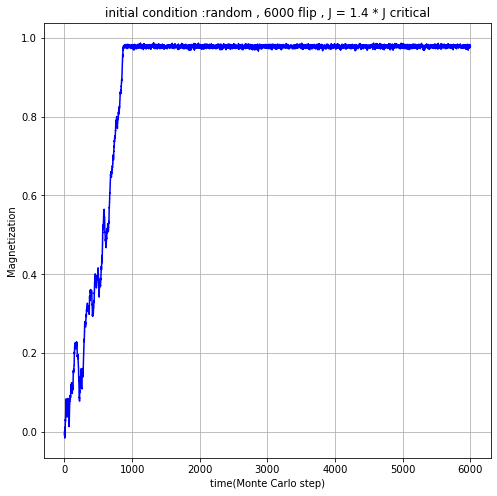

In [19]:
fig = plt.figure(figsize=(8,8))
plt.plot(M,'.b-',markersize=0.1)
plt.title("initial condition :random , 6000 flip , J = 1.4 * J critical")
plt.xlabel('time(Monte Carlo step)')
plt.ylabel('Magnetization')
plt.tick_params(labelsize=10)
plt.grid()

In [22]:
Jcrit

0.44068679350977147

sampling to calculate positional correlation length for L = 200

In [23]:
start=timeit.default_timer()
listt=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.92,0.95,0.97,0.99,1,1.01,1.03,1.05,1.08,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2]
Ksilist=[]
Ksilistvar=[]
lx, ly = 200, 200
sigma = np.random.choice([-1,1],size=(lx+2,ly+2),p=[0.5,0.5])
for a in listt:
    J = a*Jcrit #Interaction
    H = 0 #External field
    # make the initial 'full lattice'
    
    Ksi0= run_sample_ksi(6000,1) 
    ac = acf(Ksi0[2000:],length=900)
    step = corr_len(ac)
    Ksi = Ksi0[2000::step]
    
    if step is None:
        step=1
    if 1000//step < 100:
        Ksi0 =  run_sample_ksi((500*step-1000),step)
        Ksi = np.append(Ksi,Ksi0)
    Ksilist+=[np.mean(Ksi)]
    Ksilistvar+=[np.sqrt(np.var(Ksi))]
stop=timeit.default_timer()
print('creation time :',stop-start)    

<ipython-input-7-11ab8c1ead91>:14: RuntimeWarning: invalid value encountered in double_scalars
  C+=[(np.mean(Xi*Xj)-np.mean(Xi)*np.mean(Xj))/np.var(Xi)]
C:\Users\mashadservice.ir\anaconda3\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


creation time : 1611.6706855999996


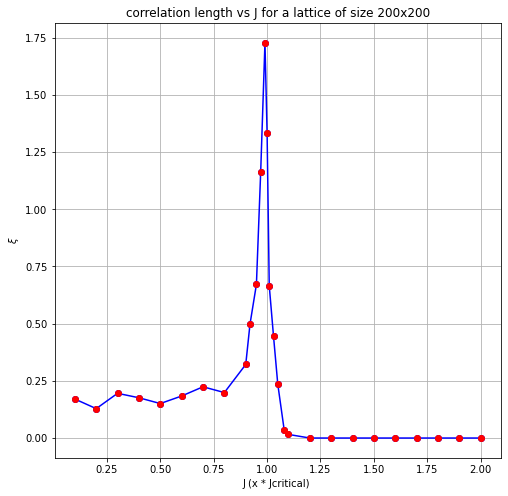

In [24]:
fig = plt.figure(figsize=(8,8))
plt.xlabel("J (x * Jcritical) ")
plt.ylabel(r'$\xi$')
plt.title("correlation length vs J for a lattice of size 200x200")
plt.errorbar(listt,Ksilist, color='r',fmt='o')
plt.plot(listt,Ksilist,'.b-',markersize=12)
plt.tick_params(labelsize=10)
plt.grid()

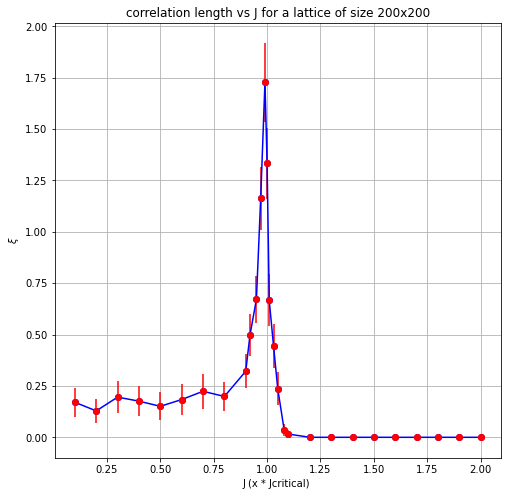

In [42]:
fig = plt.figure(figsize=(8,8))
Ksivar = np.array(Ksilistvar)
Ksivar/=20
plt.xlabel("J (x * Jcritical) ")
plt.ylabel(r'$\xi$')
plt.title("correlation length vs J for a lattice of size 200x200")
plt.errorbar(listt,Ksilist, yerr=(Ksivar), color='r',fmt='o')
plt.plot(listt,Ksilist,'.b-',markersize=12)
plt.tick_params(labelsize=10)
plt.grid()

sampling for calculation of different quantities for 100x100 lattice

In [56]:
start=timeit.default_timer()
listt=[0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.92,0.95,0.97,0.99,1,1.01,1.03,1.05,1.08,1.1,1.15,1.2,1.25,1.3,1.35,1.4,1.45,1.5,1.55,1.6,1.65,1.7,1.75,1.8]
Ksilist=[]
Ksilistvar=[]
lx, ly = 100, 100
sigma = np.random.choice([-1,1],size=(lx+2,ly+2),p=[0.5,0.5])
for a in listt:
    J = a*Jcrit #Interaction
    H = 0 #External field
    # make the initial 'full lattice'
    
    Ksi0= run_sample_ksi(6000,1) 
    ac = acf(Ksi0[2000:],length=900)
    step = corr_len(ac)
    Ksi = Ksi0[2000::step]
    
    if step is None:
        step=1
    if 1000//step < 100:
        Ksi0 =  run_sample_ksi((500*step-1000),step)
        Ksi = np.append(Ksi,Ksi0)
    Ksilist+=[np.mean(Ksi)]
    Ksilistvar+=[np.sqrt(np.var(Ksi))]
stop=timeit.default_timer()
print('creation time :',stop-start)   

<ipython-input-7-11ab8c1ead91>:14: RuntimeWarning: invalid value encountered in double_scalars
  C+=[(np.mean(Xi*Xj)-np.mean(Xi)*np.mean(Xj))/np.var(Xi)]
C:\Users\mashadservice.ir\anaconda3\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


creation time : 4532.804272700001


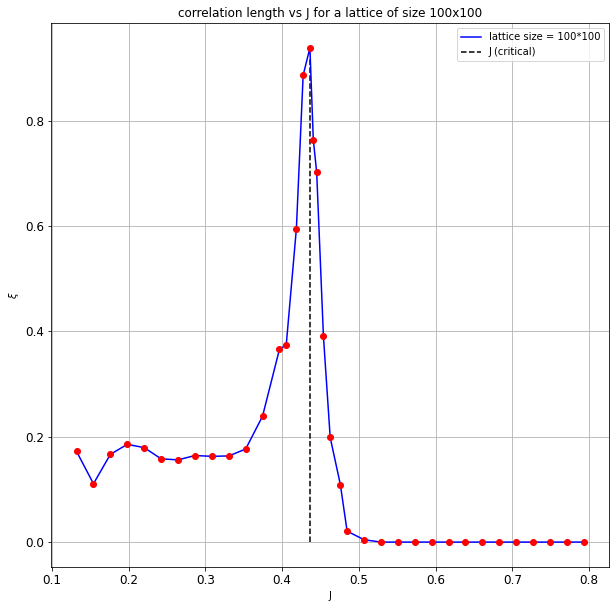

In [306]:
fig = plt.figure(figsize=(10,10))
listj = [i*Jcrit for i in listt]
plt.xlabel("J")
plt.ylabel(r'$\xi$')
plt.title("correlation length vs J for a lattice of size 100x100")
plt.errorbar(listj,Ksilist, color='r',fmt='o')
plt.plot(listj,Ksilist,'b-',markersize=5,label = "lattice size = 100*100")
plt.vlines([0.99*Jcrit],0,0.92,linestyle='dashed',label = 'J (critical)',linewidth=1.5)
plt.tick_params(labelsize=12)
plt.legend()
plt.grid()

In [303]:
#Critical point
J_crit100k = np.argmax(Ksilist)
listt[J_crit100k]
Jcrit100k =listt[J_crit100k] * Jcrit
Jcrit100k

0.43627992557467377

In [304]:
listt[J_crit100k]

0.99

sampling for calculation of different quantities for 100x100 lattice

In [260]:
start=timeit.default_timer()
listt=[0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.92,0.95,0.97,0.99,1,1.01,1.03,1.05,1.08,1.1,1.15,1.2,1.25,1.3,1.35,1.4,1.45,1.5,1.55,1.6,1.65,1.7,1.75,1.8]
Mlist=[]
Elist=[]
Xilist=[]
Cvlist=[]
lx, ly = 100, 100
sigma = np.random.choice([-1,1],size=(lx+2,ly+2),p=[0.5,0.5])
for a in listt:
    J = a*Jcrit #Interaction
    H = 0 #External field
    # make the initial 'full lattice'
    
    M, E,Step = Generate(sigma,J,H)
    Mlist+=[np.mean(M)]
    Elist+=[np.mean(E)]
    Xilist+=[np.var(M)]
    Cvlist+=[np.var(E)]
stop=timeit.default_timer()
print('creation time :',stop-start)      

creation time : 597.0865848999965


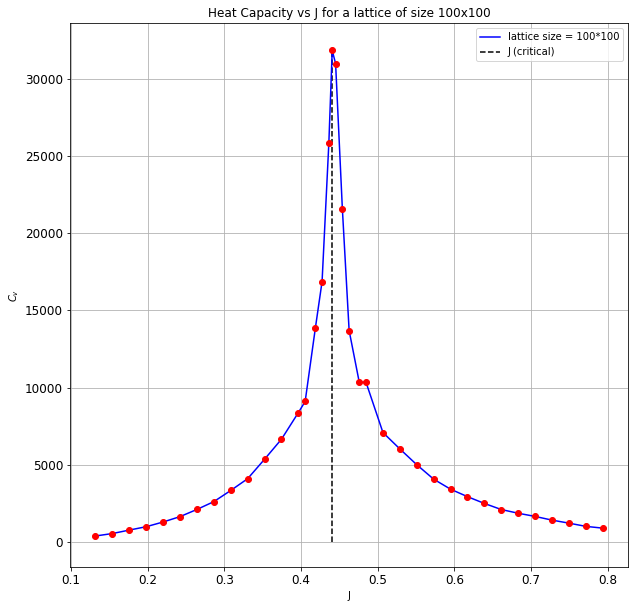

In [261]:
#Heat Capacity
fig = plt.figure(figsize=(10,10))
listj = [i*Jcrit for i in listt]
plt.xlabel("J")
plt.ylabel(r'$C_{v}$')
plt.title("Heat Capacity vs J for a lattice of size 100x100")
plt.errorbar(listj,Cvlist, color='r',fmt='o')
plt.plot(listj,Cvlist,'b-',markersize=5,label = "lattice size = 100*100")
plt.vlines([Jcrit],0,32000,linestyle='dashed',label = 'J (critical)',linewidth=1.5)
plt.tick_params(labelsize=12)
plt.legend(loc='upper right')
plt.grid()

In [293]:
J_crit100 = np.argmax(Cvlist)
listt[J_crit100]
Jcrit100 =listt[J_crit100] * Jcrit
Jcrit100

0.44068679350977147

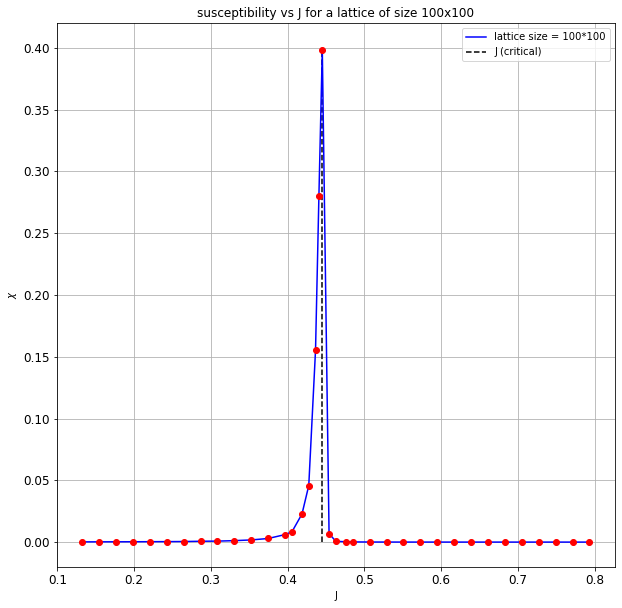

In [296]:
#Susceptibility
fig = plt.figure(figsize=(10,10))
plt.xlabel("J")
plt.ylabel(r'$\chi$')
plt.title("susceptibility vs J for a lattice of size 100x100")
plt.errorbar(listj,Xilist, color='r',fmt='o')
plt.plot(listj,Xilist,'b-',markersize=5,label = "lattice size = 100*100")
plt.vlines([Jcrit100X],0,0.4,linestyle='dashed',label = 'J (critical)',linewidth=1.5)
plt.tick_params(labelsize=12)
plt.legend()
plt.grid()

In [295]:
#Critical point
J_crit100X = np.argmax(Xilist)
listt[J_crit100X]
Jcrit100X =listt[J_crit100X] * Jcrit
Jcrit100X

0.44509366144486917

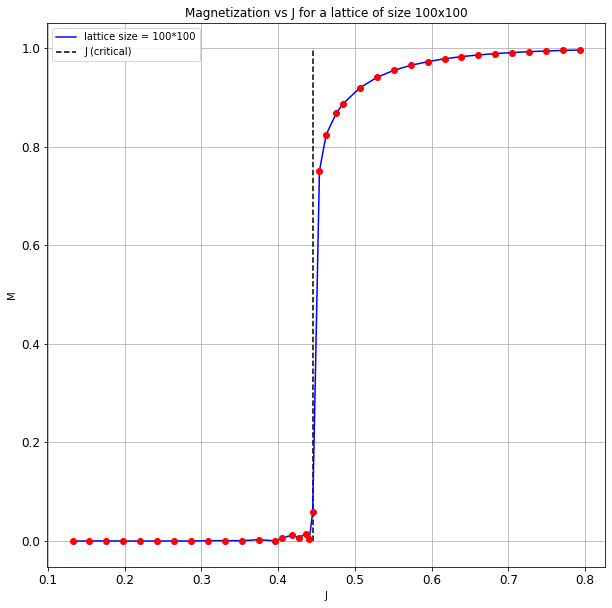

In [299]:
#Magnetization
fig = plt.figure(figsize=(10,10))
Mlist=np.array(Mlist)
Xibar = np.sqrt(Xilist)
Xibar = np.array(Xibar)
Xibar/=100
plt.xlabel("J")
plt.ylabel("M")
plt.title("Magnetization vs J for a lattice of size 100x100")
plt.errorbar(listj,np.abs(Mlist),yerr=Xibar, color='r',fmt='o',)
plt.plot(listj,np.abs(Mlist),'b-',markersize=3,label = "lattice size = 100*100")
plt.vlines([1.01*Jcrit], 0,1, linestyle='dashed',label='J (critical)',linewidth=1.5)
plt.tick_params(labelsize=12)
plt.legend()
plt.grid()

In [297]:
np.abs(Mlist)

array([2.52000000e-05, 1.93500000e-04, 2.61650000e-04, 5.33500000e-05,
       7.07500000e-05, 3.30500000e-05, 2.05850000e-04, 2.73000000e-05,
       7.21700000e-04, 8.64200000e-04, 6.45650000e-04, 2.78625000e-03,
       4.64025357e-04, 5.62195946e-03, 1.26332710e-02, 6.52906977e-03,
       1.52598020e-02, 3.18821218e-03, 5.85753906e-02, 7.50717460e-01,
       8.24373856e-01, 8.67743808e-01, 8.86980600e-01, 9.19225000e-01,
       9.40183500e-01, 9.54539350e-01, 9.64616800e-01, 9.72080000e-01,
       9.77968450e-01, 9.82332950e-01, 9.85725600e-01, 9.88448550e-01,
       9.90591700e-01, 9.92345050e-01, 9.93742250e-01, 9.94854400e-01,
       9.95790550e-01])

In [301]:
Jcrit100m = 1.01*Jcrit
Jcrit100m

0.44509366144486917

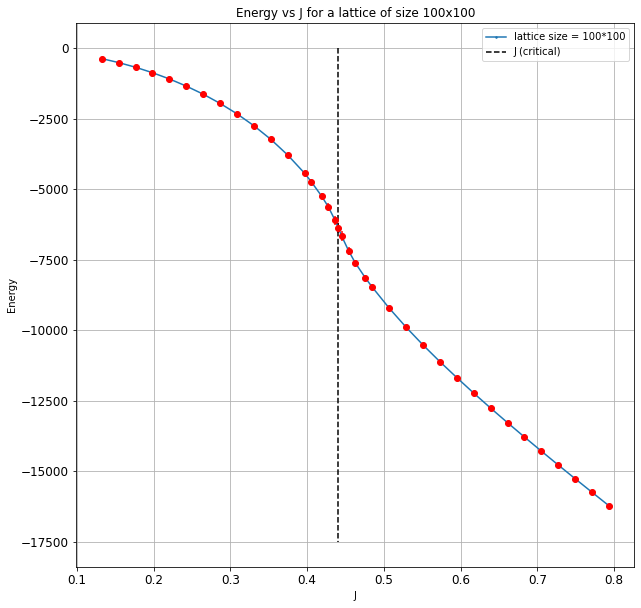

In [276]:
#Energy
fig = plt.figure(figsize=(10,10))
listj = [i*Jcrit for i in listt]
plt.xlabel("J")
plt.ylabel("Energy")
plt.title("Energy vs J for a lattice of size 100x100")
plt.errorbar(listj,Elist,yerr=np.sqrt(Cvlist), color='r',fmt='o')
plt.plot(listj,Elist,'.-',markersize=3,label = "lattice size = 100*100")
plt.vlines([Jcrit], 0,-17500, linestyle='dashed',label = 'J (critical)',linewidth=1.5)
plt.tick_params(labelsize=12)
plt.legend()
plt.grid()

sampling for different lattice lengths

L=100

In [145]:
start=timeit.default_timer()
listt1=[0.1,0.2,0.30,0.35,0.41,0.42,0.43,0.432,0.435,0.44,0.441,0.445,0.5,0.6,0.7,0.8]
Mlist1=[]
Elist1=[]
Xilist1=[]
Cvlist1=[]
lx, ly = 100, 100
sigma = np.random.choice([-1,1],size=(lx+2,ly+2),p=[0.5,0.5])
for a in listt1:
    J = a #Interaction
    H = 0 #External field
    # make the initial 'full lattice'
    
    M, E,Step = Generate(sigma,J,H)
    Mlist1+=[np.mean(M)]
    Elist1+=[np.mean(E)]
    Xilist1+=[np.var(M)]
    Cvlist1+=[np.var(E)]
stop=timeit.default_timer()
print('creation time :',stop-start)  

creation time : 429.745818899999


L=150

In [146]:
start=timeit.default_timer()
listt2=[0.1,0.2,0.30,0.35,0.41,0.42,0.43,0.432,0.435,0.44,0.441,0.445,0.5,0.6,0.7,0.8]
Mlist2=[]
Elist2=[]
Xilist2=[]
Cvlist2=[]
lx, ly = 150, 150
sigma = np.random.choice([-1,1],size=(lx+2,ly+2),p=[0.5,0.5])
for a in listt2:
    J = a #Interaction
    H = 0 #External field
    # make the initial 'full lattice'
    
    M, E,Step = Generate(sigma,J,H)
    Mlist2+=[np.mean(M)]
    Elist2+=[np.mean(E)]
    Xilist2+=[np.var(M)]
    Cvlist2+=[np.var(E)]
stop=timeit.default_timer()
print('creation time :',stop-start)   

creation time : 1107.0325681999966


L = 200

In [147]:
start=timeit.default_timer()
listt3=[0.1,0.2,0.30,0.35,0.41,0.42,0.43,0.432,0.435,0.44,0.441,0.445,0.5,0.6,0.7,0.8]
Mlist3=[]
Elist3=[]
Xilist3=[]
Cvlist3=[]
lx, ly = 200, 200
sigma = np.random.choice([-1,1],size=(lx+2,ly+2),p=[0.5,0.5])
for a in listt3:
    J = a #Interaction
    H = 0 #External field
    # make the initial 'full lattice'
    
    M, E,Step = Generate(sigma,J,H)
    Mlist3+=[np.mean(M)]
    Elist3+=[np.mean(E)]
    Xilist3+=[np.var(M)]
    Cvlist3+=[np.var(E)]
stop=timeit.default_timer()
print('creation time :',stop-start)    

creation time : 1703.5811536000037


L = 250

In [148]:
start=timeit.default_timer()
listt4=[0.1,0.2,0.30,0.35,0.41,0.42,0.43,0.432,0.435,0.44,0.441,0.445,0.5,0.6,0.7,0.8]
Mlist4=[]
Elist4=[]
Xilist4=[]
Cvlist4=[]
lx, ly = 250, 250
sigma = np.random.choice([-1,1],size=(lx+2,ly+2),p=[0.5,0.5])
for a in listt4:
    J = a #Interaction
    H = 0 #External field
    # make the initial 'full lattice'
    
    M, E,Step = Generate(sigma,J,H)
    Mlist4+=[np.mean(M)]
    Elist4+=[np.mean(E)]
    Xilist4+=[np.var(M)]
    Cvlist4+=[np.var(E)]
stop=timeit.default_timer()
print('creation time :',stop-start)  

creation time : 3039.005567100001


L = 300

In [149]:
start=timeit.default_timer()
listt5=[0.1,0.2,0.30,0.35,0.41,0.42,0.43,0.432,0.435,0.44,0.441,0.445,0.5,0.6,0.7,0.8]
Mlist5=[]
Elist5=[]
Xilist5=[]
Cvlist5=[]
lx, ly = 300, 300
sigma = np.random.choice([-1,1],size=(lx+2,ly+2),p=[0.5,0.5])
for a in listt5:
    J = a #Interaction
    H = 0 #External field
    # make the initial 'full lattice'
    
    M, E,Step = Generate(sigma,J,H)
    Mlist5+=[np.mean(M)]
    Elist5+=[np.mean(E)]
    Xilist5+=[np.var(M)]
    Cvlist5+=[np.var(E)]
stop=timeit.default_timer()
print('creation time :',stop-start)       

creation time : 5516.4718389000045


visualization of different quantities for different lattices

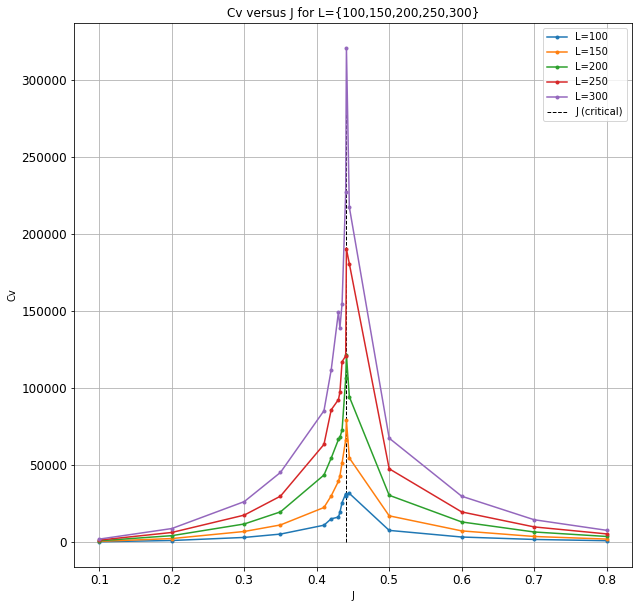

In [206]:
fig = plt.figure(figsize=(10,10))
plt.xlabel("J")
plt.ylabel("Cv")
plt.title("Cv versus J for L={100,150,200,250,300}")
plt.plot(listt1,Cvlist1,'o-',markersize=3,label='L=100')
plt.plot(listt2,Cvlist2,'o-',markersize=3,label='L=150')
plt.plot(listt3,Cvlist3,'o-',markersize=3,label='L=200')
plt.plot(listt4,Cvlist4,'o-',markersize=3,label='L=250')
plt.plot(listt5,Cvlist5,'o-',markersize=3,label='L=300')
plt.vlines([Jcrit], 0,300000, linestyle='dashed',label='J (critical)',linewidth=1)
plt.tick_params(labelsize=12)
plt.legend()
plt.grid()

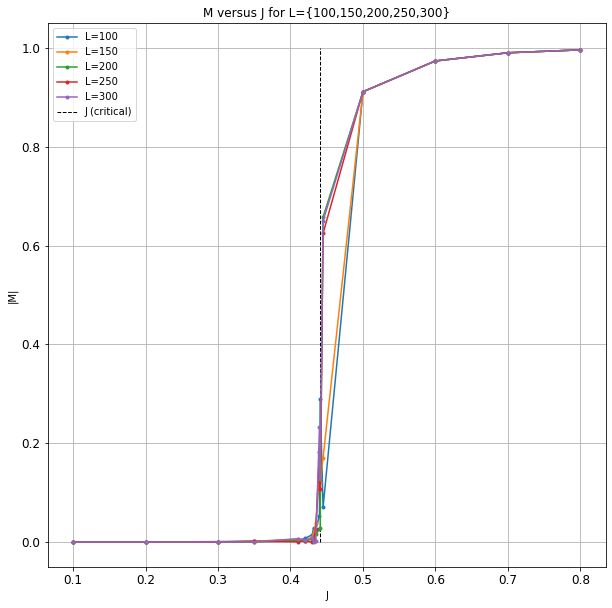

In [208]:
fig = plt.figure(figsize=(10,10))
plt.xlabel("J")
plt.ylabel("|M|")
plt.title("M versus J for L={100,150,200,250,300}")
plt.plot(listt1,np.abs(Mlist1),'o-',markersize=3,label='L=100')
plt.plot(listt2,np.abs(Mlist2),'o-',markersize=3,label='L=150')
plt.plot(listt3,np.abs(Mlist3),'o-',markersize=3,label='L=200')
plt.plot(listt4,np.abs(Mlist4),'o-',markersize=3,label='L=250')
plt.plot(listt5,np.abs(Mlist5),'o-',markersize=3,label='L=300')
plt.vlines([Jcrit], 0,1, linestyle='dashed',label='J (critical)',linewidth=1)
plt.tick_params(labelsize=12)
plt.legend()
plt.grid()

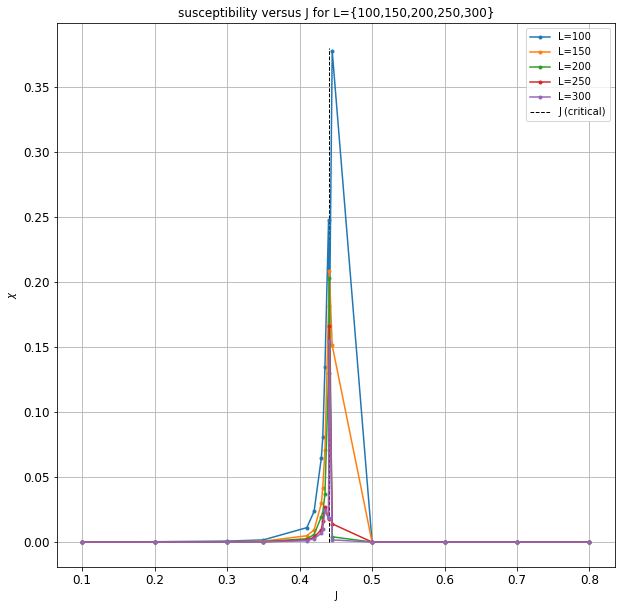

In [209]:
fig = plt.figure(figsize=(10,10))
plt.xlabel("J")
plt.ylabel(r'$\chi$')
plt.title("susceptibility versus J for L={100,150,200,250,300}")
plt.plot(listt1,Xilist1,'o-',markersize=3,label='L=100')
plt.plot(listt2,Xilist2,'o-',markersize=3,label='L=150')
plt.plot(listt3,Xilist3,'o-',markersize=3,label='L=200')
plt.plot(listt4,Xilist4,'o-',markersize=3,label='L=250')
plt.plot(listt5,Xilist5,'o-',markersize=3,label='L=300')
plt.vlines([Jcrit], 0,0.38, linestyle='dashed',label='J (critical)',linewidth=1)
plt.tick_params(labelsize=12)
plt.legend()
plt.grid()

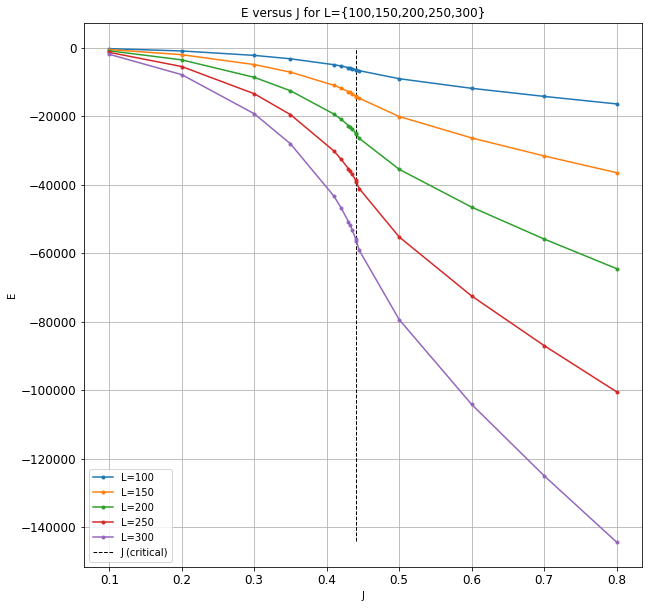

In [210]:
fig = plt.figure(figsize=(10,10))
plt.xlabel("J")
plt.ylabel("E")
plt.title("E versus J for L={100,150,200,250,300}")
plt.plot(listt1,Elist1,'o-',markersize=3,label='L=100')
plt.plot(listt2,Elist2,'o-',markersize=3,label='L=150')
plt.plot(listt3,Elist3,'o-',markersize=3,label='L=200')
plt.plot(listt4,Elist4,'o-',markersize=3,label='L=250')
plt.plot(listt5,Elist5,'o-',markersize=3,label='L=300')
plt.vlines([Jcrit], -144000,0, linestyle='dashed',label='J (critical)',linewidth=1)
plt.tick_params(labelsize=12)
plt.legend()
plt.grid()

showing lattice for J = 0.5 * Jcritical

In [221]:
J = 0.5 *Jcrit
H = 0
Lx,Ly = 100,100
sigma = np.ones((Lx,Ly), dtype='i4')

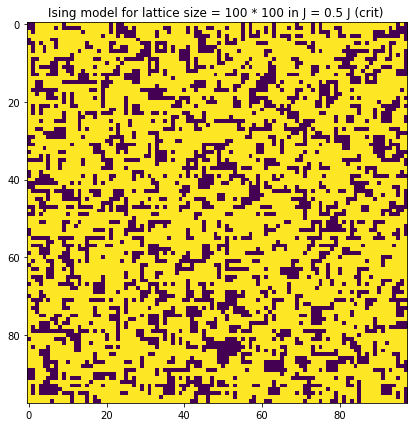

In [222]:
plt.rcParams["figure.figsize"] = (7,7)
mcflip(sigma, J, H)
plt.imshow(sigma[1:-1,1:-1], vmin = -1, vmax = 1)
plt.title('Ising model for lattice size = 100 * 100 in J = 0.5 J (crit) ')
plt.show()